# Stacking [(ARIMAX + RNN) --> LR]

In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, pacf
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import keras

In [2]:
#2. Import dataset
data = pd.read_csv("D:\Tài liệu PTDLKD\Data_stock_SCS_VN.csv")
data

,time,open,high,low,close,volume
0,2019-03-01,59960,59960,59920,59960,34010
1,2019-03-04,59960,60080,58980,59960,8580
2,2019-03-05,58720,60010,58720,59960,35720
3,2019-03-06,59960,60130,59960,59960,9290
4,2019-03-07,59960,60400,59960,60330,19290
...,...,...,...,...,...,...
1310,2024-05-27,90900,90900,88900,90000,59200
1311,2024-05-28,89500,91000,89300,90000,109100
1312,2024-05-29,90100,91500,90000,90300,121100
1313,2024-05-30,90300,90300,88500,89700,82600


# ARIMAX

In [3]:
#3. Partition the data into necessary segments
ratio = 0.8
split = int(len(data)*ratio)

x_train_a = data[:split].index
y_train_a = data[:split][['close']]
exg_train_a = data[:split][['high','low']]

x_test_a = data[split:].index
y_test_a = data[split:][['close']]
exg_test_a = data[split:][['high','low']]

In [4]:
#4. Function for adf testing
def adf_test(dataset):
    dftest =  adfuller (dataset, autolag='AIC') 
    print("1. ADF: ",dftest[0])
    print("2. P-Value: ", round (dftest[1],6))
    print("3. Num Of Lags: ", dftest[2])
    print("4. Critical Values :")
    for key, val in dftest [4].items():
        print("\t",key, ":", val)
    if (dftest[0] < dftest [4]["5%"] or dftest[0] < dftest[4]["1%"] or dftest[0] < dftest[4]["10%"]): 
        print ("Reject H0: Time Series is Stationary")
        return True
    else:
        print ("Failed to Reject H0: Time Series is Non-Stationary") 
        return False

In [5]:
#5. Check the stationarity of the data and determine d
diff_order = 0
is_stationary = False
while not is_stationary:
    if diff_order > 0:
        train_diff = pd.DataFrame(np.diff(y_train_a['close'], diff_order))
        train_diff.index = y_train_a.index[diff_order:]
        train_diff.columns = ['close']
        diff = train_diff
    else:
        diff = y_train_a

    print('-' * 50)
    print('Difference order:', diff_order) 
    if adf_test(diff['close']):
        is_stationary =  True
    else:
        diff_order += 1
print('-' * 50)
print('Choose d =', diff_order)

--------------------------------------------------
Difference order: 0
1. ADF:  -1.725476401667419
2. P-Value:  0.418036
3. Num Of Lags:  0
4. Critical Values :
	 1% : -3.4365872439265366
	 5% : -2.8642939151214337
	 10% : -2.568236291810346
Failed to Reject H0: Time Series is Non-Stationary
--------------------------------------------------
Difference order: 1
1. ADF:  -33.53787643621438
2. P-Value:  0.0
3. Num Of Lags:  0
4. Critical Values :
	 1% : -3.4365931987759417
	 5% : -2.864296541617536
	 10% : -2.568237690702948
Reject H0: Time Series is Stationary
--------------------------------------------------
Choose d = 1


Text(0.5, 1.0, 'PACF')

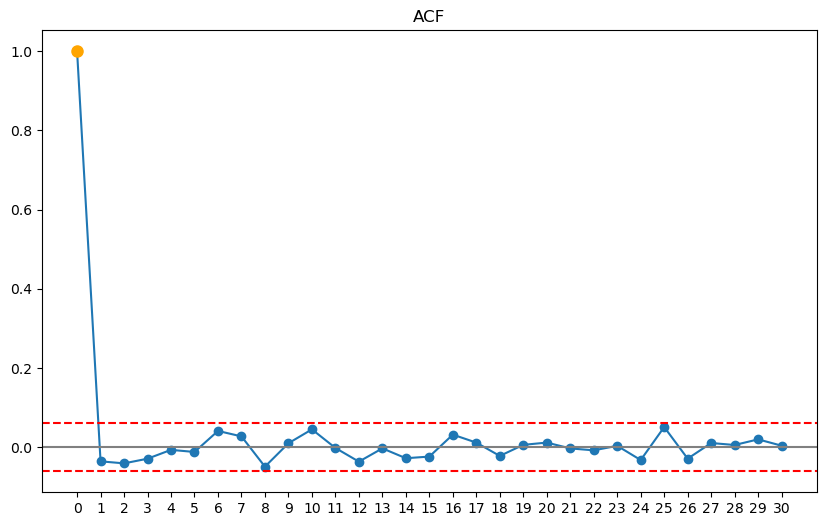

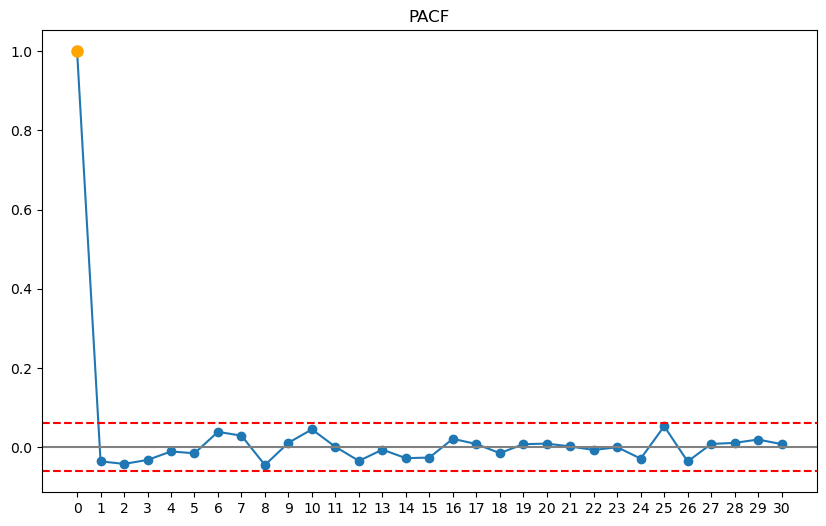

In [6]:
#6. From ACF and PACF, we determine the lists of p and q
acf_plot= acf(diff['close'])
pacf_plot= pacf(diff['close'])
limit_sig = (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3))-1) / (math.exp(2 * 1.96 / math.sqrt(len(diff['close']) - 3)) + 1)
list_q=[]
list_p=[]

# Plot ACF
plt.figure(figsize=(10, 6))
N = len(diff['close'])  
plt.plot(acf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(acf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_q.append(i)
plt.title('ACF')

# Plot PACF
plt.figure(figsize=(10, 6))
plt.plot(pacf_plot, marker='o', linestyle='-') 
plt.axhline(y=0, color="gray")
plt.axhline(y=limit_sig, color='red', linestyle='--') 
plt.axhline(y=-limit_sig, color='red', linestyle='--')
plt.xticks(np.arange(0, 31, step=1))
for i, val in enumerate(pacf_plot):
    if val > limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
    if val < -limit_sig:
        plt.plot(i, val, marker='o', markersize=8, color='orange', linestyle='None')
        list_p.append(i)
plt.title('PACF')

In [7]:
#7. Therefore, in addition to selecting the p and d values identified by PACF and ACF,we will also take additional p and d values from 0 to 5 and put them to the list_p and list_d
combined_p = set(list_p).union(range(0, 6))
list_p = list(combined_p)
combined_q = set(list_q).union(range(0, 6))
list_q = list(combined_q)

In [8]:
#8. Train the model with the new lists of p and q
signi_models = []
best_model = []
best_rmse = float('inf')

for p_value in list_p:
    for q_value in list_q:
        try:
            model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(p_value, diff_order, q_value)).fit()
            p_values = model_arimax.pvalues
            if all(p < 0.05 for p in p_values):
                signi_models.append((p_value, q_value))
            else:
                raise Exception("Model not significant")
            pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
            rmse = np.sqrt(mean_squared_error(y_test_a, pred_test_a))
            if rmse < best_rmse:
                best_model = (p_value, q_value)
                best_rmse = rmse
        except Exception as e:
            pass

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [9]:
#9. Print the list of models that have statistical significance and the model with the lowest rmse from this list
print("List model have statistical significance:")
for model_params in signi_models:
    print("- p_value:", model_params[0], ", d_value:", diff_order, ", q_value:", model_params[1])    
print("\nBest model: p=", best_model[0], ", d=", diff_order, ", q=", best_model[1])

List model have statistical significance:
- p_value: 0 , d_value: 1 , q_value: 0
- p_value: 0 , d_value: 1 , q_value: 1
- p_value: 1 , d_value: 1 , q_value: 0
- p_value: 2 , d_value: 1 , q_value: 0
- p_value: 2 , d_value: 1 , q_value: 3
- p_value: 3 , d_value: 1 , q_value: 0
- p_value: 4 , d_value: 1 , q_value: 0
- p_value: 5 , d_value: 1 , q_value: 0

Best model: p= 0 , d= 1 , q= 1


In [10]:
#10. Define and fit model with train data
model_arimax = ARIMA(y_train_a, exog=exg_train_a, order=(best_model[0], diff_order,best_model[1])).fit()
print(model_arimax.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1052
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -8154.097
Date:                Thu, 06 Jun 2024   AIC                          16316.195
Time:                        01:44:24   BIC                          16336.025
Sample:                             0   HQIC                         16323.713
                               - 1052                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
high           0.6119      0.007     81.992      0.000       0.597       0.627
low            0.3809      0.008     46.706      0.000       0.365       0.397
ma.L1         -0.9789      0.008   -120.554      0.0

# RNN

In [11]:
#11. Scaler data for RNN model
data_rnn=data.reset_index()['close']
scaler=MinMaxScaler(feature_range=(0,1))
data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))

In [12]:
#12. Split the data into train and test sets
train_size = int(ratio * len(data_rnn))
test_size = len(data_rnn) - train_size
train_rnn = data_rnn[:train_size]
test_rnn = data_rnn[train_size:]

In [13]:
#13. Function to create a dataset for RNN model
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [14]:
#14. Reshape into X=t,t+1,t+2..t+99 [samples, time steps, features] and Y=t+100 [samples]
time_step = 100
x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)

In [15]:
#15. Proceed to define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
model_rnn.add(Dropout(0.5))  
model_rnn.add(SimpleRNN(128))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
#16. Fit model with train data
model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.7193 - val_loss: 0.0063
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1558 - val_loss: 0.0264
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0990 - val_loss: 0.0064
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0711 - val_loss: 0.0056
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0516 - val_loss: 0.0018
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0429 - val_loss: 0.0013
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0332 - val_loss: 9.5464e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0316 - val_loss: 0.0016
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0239 - val_loss: 0.0021
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0233 - val_loss: 0.0020
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0173 - val_loss: 8.9186e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - l

# Linear Regression

In [17]:
#17. Prepare train data for LR Model using predictions on train data from ARIMAX and RNN Models
pred_train_a = model_arimax.predict(start= len(x_train_a), end=len(x_train_a) * 2 -1 , exog=exg_train_a)
pred_train_rnn=model_rnn.predict(x_train_rnn)
pred_train_rnn=scaler.inverse_transform(pred_train_rnn)
df_pred_train_a = pd.DataFrame({'arima': pred_train_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_train_rnn = pd.DataFrame(pred_train_rnn, columns=['rnn'])

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step


In [18]:
#18.Fit a model with inputs being the predictions of ARIMAX models, RNN model, and two features "high" and "low"
x_train_lr = pd.concat([df_pred_train_a, df_pred_train_rnn,exg_train_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_train_lr = y_train_a[(time_step+1):]
model_lr= LinearRegression()
model_lr.fit(x_train_lr, y_train_lr)

LinearRegression()

In [19]:
#19. Prepare test data for LR model using predictions on test data from ARIMAX and RNN models
pred_test_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + len(x_test_a) - 1, exog=exg_test_a)
pred_test_rnn=model_rnn.predict(x_test_rnn)
pred_test_rnn=scaler.inverse_transform(pred_test_rnn)
df_pred_test_a = pd.DataFrame({'arima': pred_test_a[(time_step+1):]}).reset_index().drop('index', axis=1)
df_pred_test_rnn = pd.DataFrame(pred_test_rnn, columns=['rnn'])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 


In [20]:
#20. Predict on the test data 
x_test_lr = pd.concat([df_pred_test_a, df_pred_test_rnn,exg_test_a[(time_step+1):].reset_index().drop(['index'], axis=1)], axis=1)
y_test_lr = y_test_a[(time_step+1):]
pred_test_lr = model_lr.predict(x_test_lr)

In [21]:
#21. Evaluate model performance using RMSE, MAPE, and MSLE
print("ARIMAX Model")
rmse = np.sqrt(mean_squared_error(pred_test_a[(time_step+1):],y_test_lr))
mape = mean_absolute_percentage_error(pred_test_a[(time_step+1):],y_test_lr) * 100
msle = mean_squared_log_error(pred_test_a[(time_step+1):],y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nRNN Model")
rmse = np.sqrt(mean_squared_error(pred_test_rnn,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_rnn,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_rnn,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

print("\nStacking Model")
rmse = np.sqrt(mean_squared_error(pred_test_lr,y_test_lr))
mape = mean_absolute_percentage_error(pred_test_lr,y_test_lr) * 100
msle = mean_squared_log_error(pred_test_lr,y_test_lr)
print("RMSE:", rmse)
print("MAPE:", mape ,"%")
print("MSLE:", msle)

ARIMAX Model
RMSE: 548.322482626004
MAPE: 0.5470168437010225 %
MSLE: 5.5134098083514466e-05

RNN Model
RMSE: 1534.3941586535384
MAPE: 1.5293979137110776 %
MSLE: 0.0004418084268729207

Stacking Model
RMSE: 532.6781448303827
MAPE: 0.5375312140316401 %
MSLE: 5.162580769789509e-05


In [22]:
#22. Function is used to predict the high and low columns for the next 30, 60, 90 days because the ARIMAX model requires exogenous variables
def predict_by_rnn(data_rnn):
    scaler=MinMaxScaler(feature_range=(0,1))
    data_rnn=scaler.fit_transform(np.array(data_rnn).reshape(-1,1))
    
    train_size = int(ratio * len(data_rnn))
    test_size = len(data_rnn) - train_size
    train_rnn = data_rnn[:train_size]
    test_rnn = data_rnn[train_size:]
    
    time_step = 100
    x_train_rnn, y_train_rnn = create_dataset(train_rnn, time_step)
    x_test_rnn, y_test_rnn = create_dataset(test_rnn, time_step)
    x_train_rnn =x_train_rnn.reshape(x_train_rnn.shape[0],x_train_rnn.shape[1] , 1)
    x_test_rnn = x_test_rnn.reshape(x_test_rnn.shape[0],x_test_rnn.shape[1] , 1)
    
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(time_step, 1)))
    model_rnn.add(Dropout(0.5))  
    model_rnn.add(SimpleRNN(128))
    model_rnn.add(Dropout(0.5))
    model_rnn.add(Dense(1))
    model_rnn.compile(loss='mean_squared_error',optimizer='adam')
    model_rnn.fit(x_train_rnn,y_train_rnn,validation_data=(x_test_rnn,y_test_rnn),epochs=50,batch_size=32,verbose=1)
      
    x_input=test_rnn[-(time_step+1):].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=100
    i=0
    while(i<90):

        if(len(temp_input)>time_step):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model_rnn.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    pred_rnn=scaler.inverse_transform(lst_output)
    
    return pred_rnn


In [23]:
#23. Predict high and low for the next 30, 60, 90 days
high_pred_rnn = predict_by_rnn(data.reset_index()['high'])
low_pred_rnn = predict_by_rnn(data.reset_index()['low'])   

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.6258 - val_loss: 0.0167
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1521 - val_loss: 0.0033
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0779 - val_loss: 0.0052
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0604 - val_loss: 0.0028
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0480 - val_loss: 0.0026
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0384 - val_loss: 9.2048e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0273 - val_loss: 0.0010
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0248 - val_loss: 0.0010
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0199 - val_loss: 8.6167e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0196 - val_loss: 0.0026
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0166 - val_loss: 0.0012
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - 

C:\Users\THAI NGOC DUNG\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.5586 - val_loss: 0.0274
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1496 - val_loss: 0.0017
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0878 - val_loss: 0.0045
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0569 - val_loss: 9.2939e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0423 - val_loss: 8.9744e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0345 - val_loss: 0.0032
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0314 - val_loss: 8.2270e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0248 - val_loss: 7.7650e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0217 - val_loss: 0.0038
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0184 - val_loss: 0.0010
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0173 - val_loss: 8.7250e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 2

In [24]:
#24. Predict close for the next 30, 60, 90 days by ARIMAX model
df_high_pred_rnn = pd.DataFrame(high_pred_rnn, columns=['high'])
df_low_pred_rnn = pd.DataFrame(low_pred_rnn, columns=['low'])
exg_pred_a = pd.concat([df_high_pred_rnn, df_low_pred_rnn], axis=1)
close_pred_a = model_arimax.predict(start=len(x_train_a), end=len(x_train_a) + 89, exog=exg_pred_a)

In [25]:
#25. Predict close for the next 30, 60, 90 days by RNN model
x_input=test_rnn[-(time_step+1):].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
lst_output=[]
n_steps=100
i=0
while(i<90):
    if(len(temp_input)>time_step):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_rnn.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
close_pred_rnn=scaler.inverse_transform(lst_output)

In [26]:
#26. Predict close for the next 30, 60, 90 days by Stacking model [(ARIMAX + RNN) --> LR]
df_close_pred_a  = pd.DataFrame({'arima': close_pred_a}).reset_index().drop('index', axis=1)
df_close_pred_rnn  = pd.DataFrame(close_pred_rnn, columns=['rnn'])
x_pred_lr = pd.concat([df_close_pred_a,df_close_pred_rnn,df_high_pred_rnn,df_low_pred_rnn], axis=1)
close_pred_stacking = model_lr.predict(x_pred_lr)

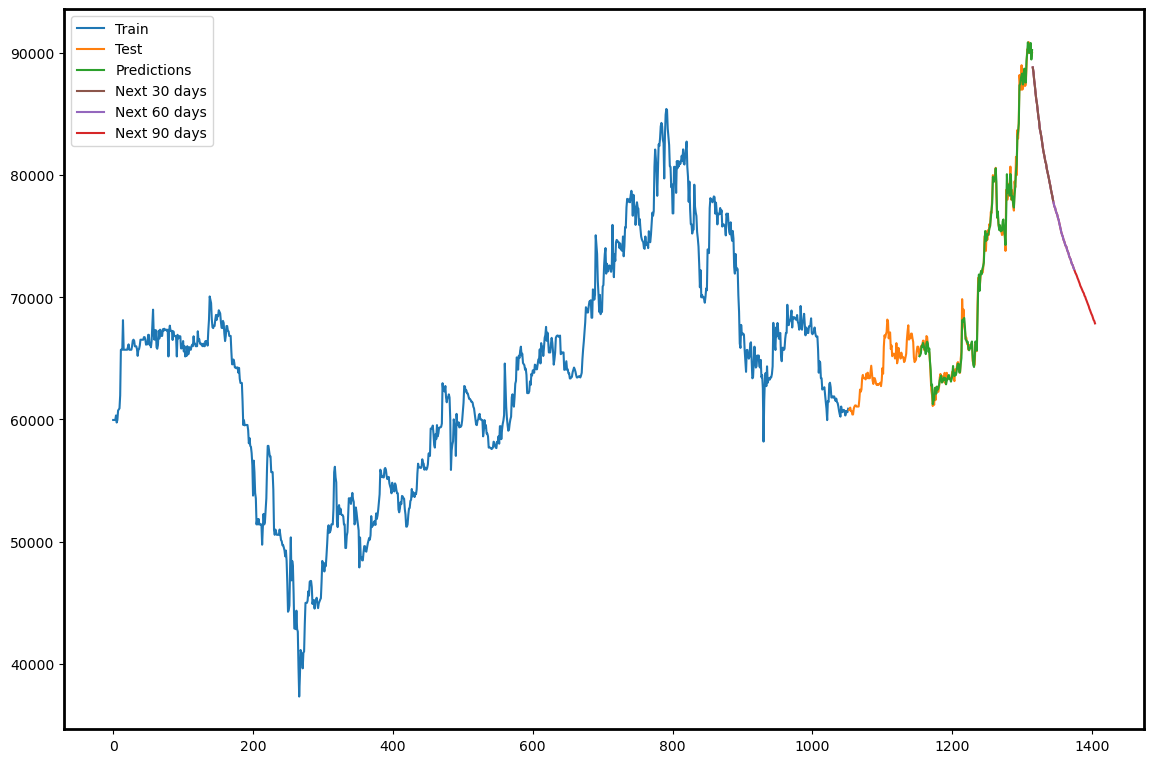

In [28]:
#27. Draw the plot 
plt.figure(figsize=(12, 8))

train_index = pd.RangeIndex(start=0, stop=train_size, step=1)
line1, = plt.plot(train_index, y_train_a, label="Train")

test_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
line2, = plt.plot(test_index, y_test_a, label="Test")

pred_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
line3, = plt.plot(pred_index, pred_test_lr, label="Predictions")

pred90_index = pd.RangeIndex(start=len(data), stop=len(data) + 90, step=1)
line4, = plt.plot(pred90_index, close_pred_stacking, label="Next 90 days")

pred60_index = pd.RangeIndex(start=len(data), stop=len(data) + 60, step=1)
line5, = plt.plot(pred60_index, close_pred_stacking[:60], label="Next 60 days")

pred30_index = pd.RangeIndex(start=len(data), stop=len(data) + 30, step=1)
line6, = plt.plot(pred30_index, close_pred_stacking[:30], label="Next 30 days")

plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.legend(handles=[line1, line2, line3, line6, line5, line4])
plt.savefig("D:\Tài liệu PTDLKD\Image_Result\Stacking_SCS_82.png")
plt.show()